In [1]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter

def log_format_func(value, pos):
    """Format the log ticks as 10^x with fractional powers."""
    exponent = np.log10(value)
    return f"$10^{{{exponent:.1f}}}$"  # LaTeX-style formatting

def log_format_func2(value, pos):
    """Format the log ticks as 10^x with fractional powers."""
    exponent = np.log10(value)
    return f"$10^{{{exponent:.2f}}}$"  # LaTeX-style formatting

In [2]:
M = 5

In [3]:
functions_to_call = [
    "rfsf_trp", "rfsf_cs", "rfsf_dp2", "rfsf_dp1",
]

In [4]:
renamed_functions = [
    "RFSF-TRP", "RFSF-TS", "RFSF-DP", "RFSF-DP-1D",
]

In [5]:
M = list(range(1, 10))
L = M

In [6]:
with open("../sauron_results_3/truncation_time/brownian.pkl", "rb") as f:
    time_measurements = pickle.load(f)

In [7]:
with open("../sauron_results_3/truncation_memory/brownian.pkl", "rb") as f:
    memory_measurements = pickle.load(f)

In [8]:
with open("../sauron_results_3/truncation_accuracy/brownian.pkl", "rb") as f:
    accuracy_measurements = pickle.load(f)

## Runtime

In [9]:
cpu_time_results = []
gpu_time_results = []
for i, l in enumerate(L):
    cpu_row = []
    gpu_row = []
    for j, name in enumerate(functions_to_call):
        cpu_times = time_measurements[("cpu", name, l)]
        if None in cpu_times:
            output = np.nan
        else:
            # Seems to be ms
            output = sum(cpu_times[1:]) / (len(cpu_times) - 1) / 1e3
        cpu_row.append(output)

        gpu_times = time_measurements[("gpu", name, l)]
        if None in gpu_times:
            output = np.nan
        else:
            output = sum(gpu_times[1:]) / (len(gpu_times) - 1) 
        gpu_row.append(output)

    cpu_time_results.append(cpu_row)
    gpu_time_results.append(gpu_row)

In [10]:
cpu_time_df = pd.DataFrame(cpu_time_results, index = L, columns=renamed_functions).round(3)

In [11]:
gpu_time_df = pd.DataFrame(gpu_time_results, index = L, columns=renamed_functions).round(3)

## Memory

In [12]:
cpu_memory_results = []
gpu_memory_results = []
for i, l in enumerate(L):
    cpu_row = []
    gpu_row = []
    for j, name in enumerate(functions_to_call):
        # cpu_current, cpu_peak, gpu_current, gpu_peak
        memory = memory_measurements[(name, l)]
        if memory == None:
            cpu_output = np.nan
            gpu_output = np.nan
        else:
            # cpu_peak
            cpu_output = memory[1] / 1e6
            # used_bytes
            gpu_output = memory[3] / 1e6
        cpu_row.append(cpu_output)
        gpu_row.append(gpu_output)
    cpu_memory_results.append(cpu_row)
    gpu_memory_results.append(gpu_row)

In [13]:
cpu_memory_df = pd.DataFrame(cpu_memory_results, index = L, columns=renamed_functions).round(3)

In [14]:
gpu_memory_df = pd.DataFrame(gpu_memory_results, index = L, columns=renamed_functions).round(3)

In [15]:
rmse_results = []
mape_results = []
for i, l in enumerate(L):
    rmse_row = []
    mape_row = []
    for j, name in enumerate(functions_to_call):
        accuracy = accuracy_measurements[(name, l)]
        if accuracy == None:
            rmse_output = np.nan
            mape_output = np.nan
        else:
            # cpu_peak
            rmse_output = accuracy[0]
            # used_bytes
            mape_output = accuracy[1]
        rmse_row.append(rmse_output)
        mape_row.append(mape_output)
    rmse_results.append(rmse_row)
    mape_results.append(mape_row)

In [16]:
rmse_df = pd.DataFrame(rmse_results, index = L, columns=renamed_functions).round(3)

In [17]:
mape_df = pd.DataFrame(mape_results, index = L, columns=renamed_functions).round(3)

## Figure 5

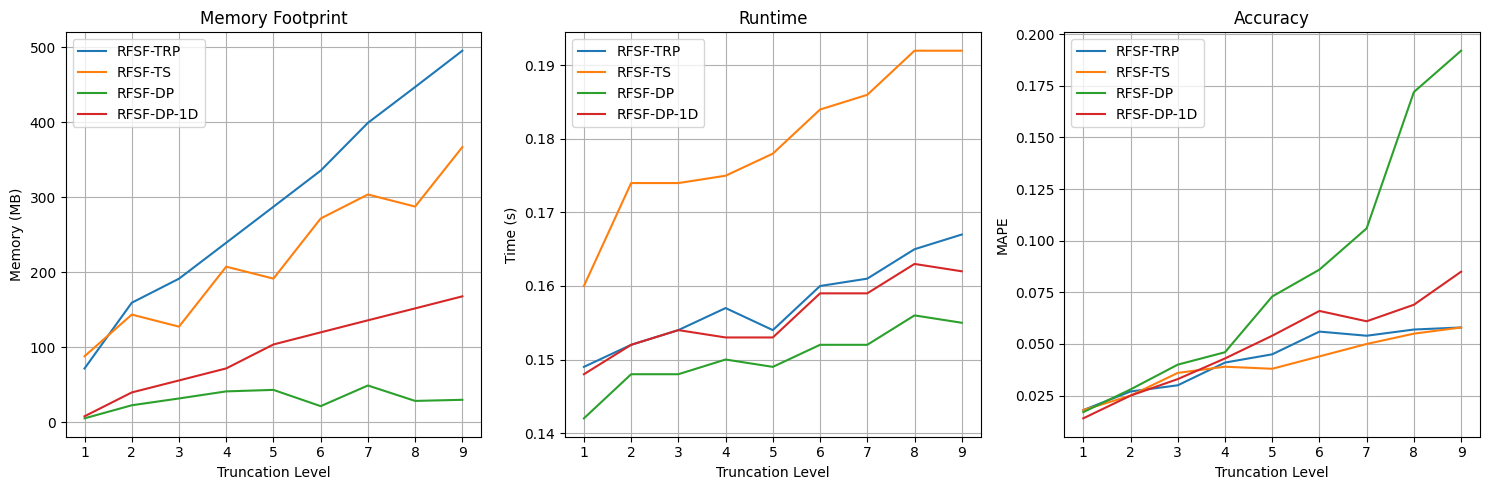

In [18]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax_ = ax[0]
df = gpu_memory_df
for name in renamed_functions:
    ax_.plot(M, df[name], label=name)
ax_.legend()
# ax_.semilogy()

# ax_.yaxis.set_major_locator(LogLocator(base=10**0.2))
# ax_.yaxis.set_major_formatter(FuncFormatter(log_format_func))
# ax_.yaxis.set_minor_locator(LogLocator(base=10**0.1))
# ax_.yaxis.set_minor_formatter("")

ax_.set_xlabel(r"Truncation Level")
ax_.set_ylabel(r"Memory (MB)")
ax_.set_title("Memory Footprint")
ax_.grid()

ax_ = ax[1]
df = gpu_time_df
for name in renamed_functions:
    ax_.plot(M, df[name], label=name)
ax_.legend()
# ax_.semilogy()

# ax_.yaxis.set_major_locator(LogLocator(base=10**0.05))
# ax_.yaxis.set_major_formatter(FuncFormatter(log_format_func2))
# ax_.yaxis.set_minor_locator(LogLocator(base=10**0.05))
# ax_.yaxis.set_minor_formatter("")

ax_.set_xlabel(r"Truncation Level")
ax_.set_ylabel(r"Time (s)")
ax_.set_title("Runtime")
ax_.grid()

ax_ = ax[2]
df = mape_df
for name in renamed_functions:
    ax_.plot(M, df[name], label=name)
ax_.legend()
# ax_.semilogy()

# ax_.yaxis.set_major_locator(LogLocator(base=10**0.2))
# ax_.yaxis.set_major_formatter(FuncFormatter(log_format_func))
# ax_.yaxis.set_minor_locator(LogLocator(base=10**0.1))
# ax_.yaxis.set_minor_formatter("")

ax_.set_xlabel(r"Truncation Level")
ax_.set_ylabel(r"MAPE")
ax_.set_title("Accuracy")
ax_.grid()

plt.tight_layout()
plt.savefig("truncation_level.png")